In [1]:
import pandas as pd
import torch
torch.set_printoptions(linewidth=10000)

In [3]:
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.utils.data as data
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F

class StableSoftmax(nn.Module):
    def forward(self, x):
        x = x - x.max(dim=-1, keepdim=True).values
        return torch.softmax(x, dim=-1)

class Softermax(nn.Module):
    def __init__(self, dim=1):
        super(Softermax, self).__init__()
        self.dim = dim

    def forward(self, x):
        softplus_x = F.softplus(x)  # Applying softplus to each element in x
        return softplus_x / torch.sum(softplus_x, dim=self.dim, keepdim=True)

class Chess_CNN(nn.Module):
    def __init__(self):
        super(Chess_CNN, self).__init__()
        self.conv1 = nn.Conv2d(6, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.fc1 = nn.Linear(64 * 32, 1024)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(1024, 64)
        self.smax = Softermax()

    def forward(self, x):
        x = x.float()
        x = self.conv1(x)
        x = self.relu1(x)
        # x = self.conv2(x)
        # x = self.relu2(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.smax(x)
        x = x.view(x.size(0), 8, 8)
        return x
    
model = Chess_CNN()

model.load_state_dict(torch.load("models/m1_v11.pth"), strict=False)

<All keys matched successfully>

In [ ]:
# df = pd.read_csv("datasets/chess_data.csv")

def board2tensor(board):
    ranks = board.split("/")

    # [PA, KN, BI, RO, QU, KI]
    res = [[], [], [], [], [], []]

    for i in range(len(ranks) - 1, -1, -1):
        PA, KN, BI, RO, QU, KI = [], [], [], [], [], []
        for char in ranks[i]:
            if char.isdigit():
                for j in range(int(char)):
                    PA.append(0)
                    KN.append(0)
                    BI.append(0)
                    RO.append(0)
                    QU.append(0)
                    KI.append(0)
                continue
            PA_a = 0
            KN_a = 0
            BI_a = 0
            RO_a = 0
            QU_a = 0
            KI_a = 0
            if char == 'P': PA_a = 1
            elif char == 'N': KN_a = 1
            elif char == 'B': BI_a = 1
            elif char == 'R': RO_a = 1
            elif char == 'Q': QU_a = 1
            elif char == 'K': KI_a = 1
            elif char == 'p': PA_a = -1
            elif char == 'n': KN_a = -1
            elif char == 'b': BI_a = -1
            elif char == 'r': RO_a = -1
            elif char == 'q': QU_a = -1
            elif char == 'k': KI_a = -1

            PA.append(PA_a)
            KN.append(KN_a)
            BI.append(BI_a)
            RO.append(RO_a)
            QU.append(QU_a)
            KI.append(KI_a)


        res[0].append(PA)
        res[1].append(KN)
        res[2].append(BI)
        res[3].append(RO)
        res[4].append(QU)
        res[5].append(KI)
    print(res[0])
    
    input = torch.tensor(res)

    #print(input.shape)

    with torch.no_grad():  
        output = model(input.unsqueeze(0)).unsqueeze(0)
    
    return torch.cat((input, torch.squeeze(output, dim=0)), dim=0)


def position2tensor(position):
    res = [[0] * 8 for i in range(0, 8)]
    pos_dict = {
        'a' : 0,
        'b' : 1,
        'c' : 2,
        'd' : 3,
        'e' : 4,
        'f' : 5,
        'g' : 6,
        'h' : 7
    }

    col = pos_dict[position[0]]
    row = int(position[1]) - 1
    res[row][col] = 1
    return torch.tensor(res)


[[0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [-1, -1, -1, -1, -1, -1, -1, -1], [0, 0, 0, 0, 0, 0, 0, 0]]


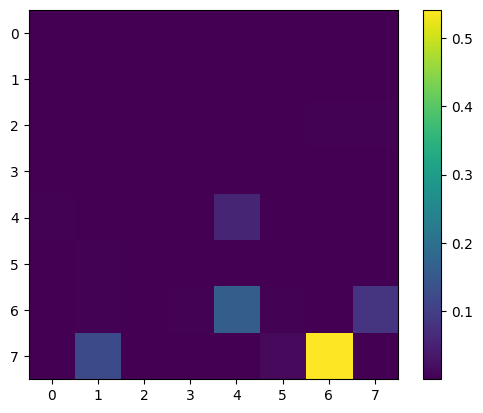

tensor([[3.7470e-07, 1.5105e-07, 2.4459e-07, 3.3672e-08, 2.1758e-07, 7.8733e-09, 4.8380e-07, 1.7544e-07],
        [3.7387e-07, 6.4229e-07, 5.2777e-05, 4.6446e-07, 9.8230e-10, 2.7333e-08, 6.2363e-09, 8.9008e-08],
        [2.0958e-04, 6.2155e-05, 3.4439e-05, 2.3818e-04, 3.6609e-06, 3.1002e-04, 3.1040e-03, 3.4136e-03],
        [3.1416e-04, 8.4897e-05, 8.5793e-06, 9.3756e-06, 1.1266e-06, 6.9081e-08, 4.2759e-06, 7.9684e-06],
        [3.2853e-03, 3.4640e-06, 4.3723e-05, 1.0515e-07, 5.5970e-02, 1.0896e-07, 1.7173e-05, 1.5225e-05],
        [2.5015e-07, 4.1555e-03, 3.3887e-05, 7.4621e-07, 4.7683e-04, 3.0924e-05, 7.0622e-06, 4.2638e-06],
        [1.8588e-04, 2.7377e-03, 7.1463e-05, 2.9423e-03, 1.5944e-01, 3.6894e-03, 5.2463e-04, 8.1625e-02],
        [1.0747e-04, 1.2149e-01, 2.0439e-04, 3.6761e-05, 3.7476e-07, 1.3153e-02, 5.4163e-01, 2.5486e-04]])


In [ ]:
import matplotlib.pyplot as plt

res = board2tensor("rnb1r2k/pp1p1Qp1/3b3p/2p1N1q1/3PB3/8/PPP2PPP/R4RK1")[6, :, :]
#print(position2tensor("f3"))
board = torch.flip(res, dims=[0])

plt.imshow(board, cmap='viridis', interpolation='nearest')

# Add colorbar for reference
plt.colorbar()

# Show the plot
plt.show()

print(board)


In [ ]:
# chess_boards = []
# chess_moves = []

# for i in range(len(df)):
#     board = df.iloc[i]["board"]
#     move = df.iloc[i]["move"]
#     chess_boards.append(board2tensor(board))
#     chess_moves.append(position2tensor(move))
#     if i % 100 == 0:
#         print(f"Converting: {i}")

# torch.save(chess_boards, "datasets/chess_boards_m1.pt")
# torch.save(chess_moves, "datasets/chess_moves_m1.pt")
